# Climate Portfolio Post: byandell

The [Global Historical Climatology Network - Daily
(GHCN-Daily/GHCNd)](https://doi.org/10.7289/V5D21VHZ)
dataset integrates daily climate observations from ~30 data sources,
containing station-based measurements from >90K land-based stations
worldwide beginning in 1880, 2/3 with only precipitation (inches).
Other meteorological elements may include daily max, min and at measurement
temperature (Fahrenheit), and snowfall and snow depth.
Over 25K stations have recent updates. The dataset is routinely reconstructed
(usually weekly) to ensure GHCNd syncs with other constituent sources. 

I initially picked Madison, WI
[GHCND:US1WIDA0063](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:US1WIDA0063).
However, it only has data from 2018.
Picking instead St Paul, MN
[GHCND:USW00014922](https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014922),
with data since 1938.

Source: Menne MJ et al. (2012) Global Historical Climatology Network - Daily (GHCN-Daily), Version 3. NOAA National Climatic Data Center. [doi:10.7289/V5D21VHZ](https://doi.org/10.7289/V5D21VHZ).

## Import libraries and read data

In [23]:
# Import required packages
import pandas as pd
import numpy as np
# Advanced options on matplotlib/seaborn/pandas plots
import matplotlib.pyplot as plt
# Common statistical plots for tabular data
import seaborn as sns
# Fit an OLS linear regression
from sklearn.linear_model import LinearRegression, RANSACRegressor

In [24]:
# Set up URL.
MSP_URL = (
    'https://www.ncei.noaa.gov/access/services/data/v1'
    '?dataset=daily-summaries'
    '&dataTypes=TMIN,TMAX,PRCP'
    '&stations=USW00014922'
    '&startDate=1893-01-01&endDate=2024-10-01'
    '&units=metric')
MSP_URL

'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&dataTypes=TMIN,TMAX,PRCP&stations=USW00014922&startDate=1893-01-01&endDate=2024-10-01&units=metric'

In [25]:
# Import data into Python from NCEI API
MSP_data = pd.read_csv(
    MSP_URL,
    # define the index as Date
    index_col='DATE',
    # Indicate these data as time series type
    parse_dates=True,
    # Define missing values as NaN
    na_values=['NaN'])
MSP_data

,STATION,PRCP,TMAX,TMIN
DATE,,,,
1938-04-09,USW00014922,0.0,10.6,-1.7
1938-04-10,USW00014922,0.0,18.9,1.1
1938-04-11,USW00014922,0.0,17.2,6.1
1938-04-12,USW00014922,0.0,21.7,2.8
1938-04-13,USW00014922,0.0,25.6,7.8
...,...,...,...,...
2024-09-19,USW00014922,0.8,30.0,20.6
2024-09-20,USW00014922,0.0,27.8,16.7
2024-09-21,USW00014922,0.0,28.9,15.6


## Initial Plots

<Axes: title={'center': 'Precipitation over Time for St Paul, MN'}, xlabel='Date', ylabel='Precipitation (mm)'>

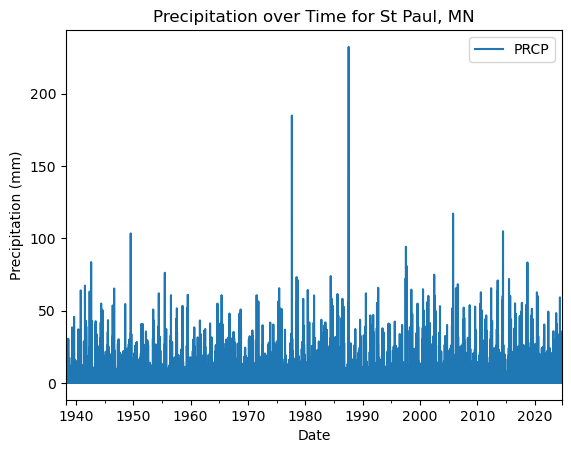

In [26]:
MSP_data.plot(
    y='PRCP',
    title='Precipitation over Time for St Paul, MN',
    xlabel='Date',
    ylabel='Precipitation (mm)')

<Axes: title={'center': 'Daily Max Temperature over Time for St Paul, MN'}, xlabel='Date', ylabel='Temperature (F)'>

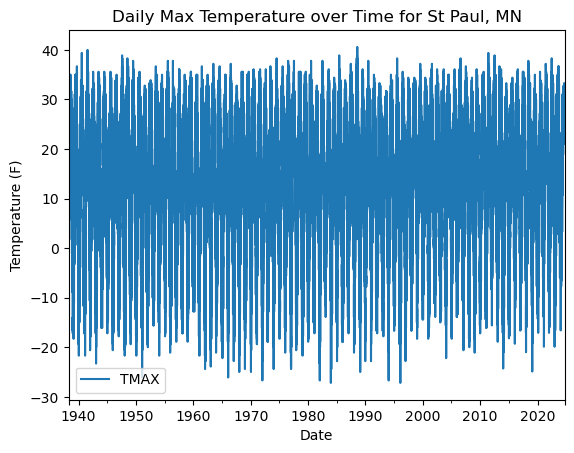

In [27]:
MSP_data.plot(
    y='TMAX',
    title='Daily Max Temperature over Time for St Paul, MN',
    xlabel='Date',
    ylabel='Temperature (F)')

## Annual Summaries

I am taking the yearly mean of `PRCP`, `TMAX` and `TMIN`.
I initially thought to use the `max` of `TMAX`, but that would have an
extreme value distribution.
Mean benefits from
[large sample theory](https://en.wikipedia.org/wiki/Asymptotic_theory_(statistics))
as the mean of many numbers tends to behave more `normally`, i.e.
symmetric and bell-shaped.
Further, the `max` of `TMAX` (not shown) tends to be mostly flat over
time, as it is sensitive only to the most extreme temperatures.

In [28]:
MSP_data = MSP_data[['PRCP', 'TMAX', 'TMIN']]
MSP_year = MSP_data.resample('YS').mean()
MSP_year

,PRCP,TMAX,TMIN
DATE,,,
1938-01-01,2.491011,18.108240,7.364419
1939-01-01,1.707123,13.747123,2.400824
1940-01-01,1.983880,11.806831,1.893443
1941-01-01,1.881918,13.825479,3.547945
1942-01-01,2.129041,12.755616,2.821370
...,...,...,...
2020-01-01,2.073497,13.588525,4.121311
2021-01-01,1.809041,14.695342,4.906027
2022-01-01,1.601096,12.800000,2.971507


<Axes: title={'center': 'Annual Max Temperature over Time for St Paul, MN'}, xlabel='Date', ylabel='Temperature (C)'>

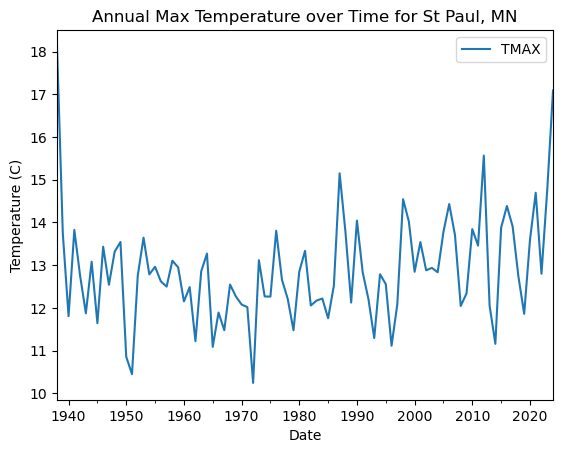

In [29]:
MSP_year.plot(
    y='TMAX',
    title='Annual Max Temperature over Time for St Paul, MN',
    xlabel='Date',
    ylabel='Temperature (C)')

## Trend lines over time

In [30]:
# Extract date index and convert to year, then reshape
D = MSP_year.index
D = pd.to_numeric(D.year)
D = D.values.reshape(-1,1)

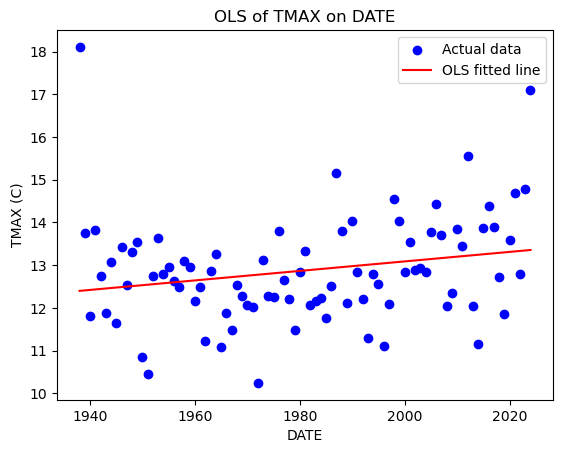

In [31]:
# Fit an OLS Linear Regression to using DATE index
# Create a linear regression model
model = LinearRegression()

T = MSP_year[['TMAX']]
# Fit the model
model.fit(D, T)

# Make predictions
T_pred = model.predict(D)

# Plot the results
plt.scatter(D, T, color='blue', label='Actual data')
plt.plot(D, T_pred, color='red', label='OLS fitted line')
plt.xlabel('DATE')
plt.ylabel('TMAX (C)')
plt.title('OLS of TMAX on DATE')
plt.legend()
plt.show()

This shows a slight upper trend, but it is likely downweighted by the
first `outlier`.
To do a first, quick look at an alternative, below is a form of
robust regression.

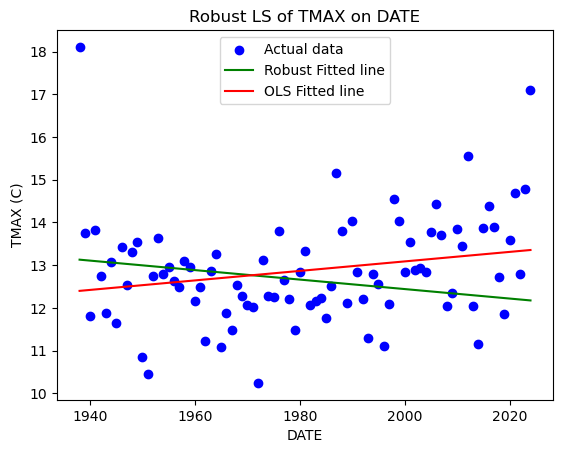

In [32]:
# Create a robust regression model 
rmodel = RANSACRegressor() 
  
# Fit the model 
rmodel.fit(D, T) 


# Make predictions
T_rpred = rmodel.predict(D)

# Plot the results
plt.scatter(D, T, color='blue', label='Actual data')
plt.plot(D, T_rpred, color='green', label='Robust Fitted line')
plt.plot(D, T_pred, color='red', label='OLS Fitted line')
plt.xlabel('DATE')
plt.ylabel('TMAX (C)')
plt.title('Robust LS of TMAX on DATE')
plt.legend()
plt.show()

### Redo trend on average annual minimum

Similar but perhaps more pronounced change in trend line
with robust regression.

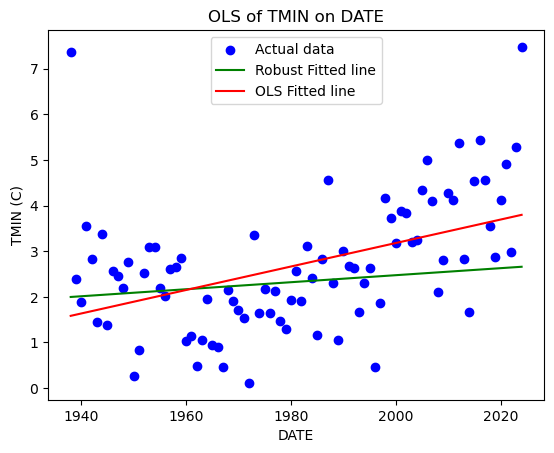

In [33]:
# Fit an OLS Linear Regression to using DATE index
# Create a linear regression model
model = LinearRegression()

t = MSP_year[['TMIN']]
# Fit the model
model.fit(D, t)

# Make predictions
t_pred = model.predict(D)

# Fit the model 
rmodel.fit(D, t) 

# Make predictions
t_rpred = rmodel.predict(D)


# Plot the results
plt.scatter(D, t, color='blue', label='Actual data')
plt.plot(D, t_rpred, color='green', label='Robust Fitted line')
plt.plot(D, t_pred, color='red', label='OLS Fitted line')
plt.xlabel('DATE')
plt.ylabel('TMIN (C)')
plt.title('OLS of TMIN on DATE')
plt.legend()
plt.show()

# Climate portfolio post: Assignment

Your turn!

## Pick a new location and/or measurement to plot
🌏 📈

Recreate the workflow you just did in a place that interests you OR with
a different measurement. You will need to make your own new Markdown and
Code cells below this one, or create a new notebook.

Your analysis should include:

1.  A researched (with citations or links) **site description**,
    including *why* you chose the site
2.  A researched (with citations or links) **data description**,
    including a **data citation**
3.  A researched (with citations or links) **methods overview**
4.  Some kind of **visual evidence** (plot, chart, diagram) for your
    results
5.  A **headline and description** for the visual evidence that
    *interprets* your analysis and puts it *in context*

You should also delete the instructions before submitting a portfolio page.

To submit your portfolio post, we're going to do something a little different this week, to see if it is easier:

 1. Put it in your portfolio repository, along with any images or interactive html visualization
 2. Add a markdown file to the `posts/02-climate` folder that contains a link to your portfolio.